In [14]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [15]:
# Read data
df = pd.read_csv('final_data.csv')

## Data Exploration and Data Cleaning

In [ ]:
# Replace price where is null with 0
df.set_value(df['price'].isnull(),'price',0)

In [17]:
# Drop rows with finished_SqFt having null value
df = df.dropna(subset=['finished_SqFt'])

In [18]:
# There are some with missing total rooms
# Fill in missing total rooms
def find_total_rooms(row):
    beds = row['bedrooms']
    baths = row['bathrooms']

    try:
        avg_rooms = int(df[(df['bedrooms'] == beds) & (df['bathrooms'] == baths)]['total_rooms'].mean())
    except:
        avg_rooms = beds + baths

    return avg_rooms
    

for i, row in df[df['total_rooms'].isnull()].iterrows():
    total_rooms = find_total_rooms(row)
    df.set_value(i, 'total_rooms', total_rooms)

In [19]:
# Convert to datetime format
df['readable_date_sold'] = pd.to_datetime(df['readable_date_sold'])
df['year_built'] = pd.to_datetime(df['year_built'], format='%Y').dt.year
df['DATE'] = pd.to_datetime(df['readable_date_sold'].apply(lambda x: x.replace(day=1)).dt.date)

In [20]:
# Create additional features
def zipcode(x):
    return str(x).zfill(5)

df['zipcode'] = df['zipcode'].apply(zipcode)


In [21]:
# bathroom / bedroom
df['bed_bath'] = df['bedrooms']/df['bathrooms']

# lot size / finished_SqFt
df['lot_finish'] = df['lot_size'] / df['finished_SqFt']

# how old the house is
df['age'] = df['readable_date_sold'].dt.year - df['year_built']

# price per finished_SqFt
df['p_sqft'] = df['price'] / df['finished_SqFt']

# finished_SqFt / total rooms
df['finishedsqft_rooms'] = df['finished_SqFt'] / df['total_rooms']
df.head()

,title,address,city,state,zipcode,price,date_sold,readable_date_sold,bedrooms,bathrooms,...,finished_SqFt,total_rooms,neighborhood,zpid,DATE,bed_bath,lot_finish,age,p_sqft,finishedsqft_rooms
0,630000,57 Sunnyside St,Boston,MA,02136,630000.0,1456383600000,2016-02-25,9,4.0,...,4765.0,16.0,Hyde Park,59128191,2016-02-01,2.250000,2.036306,126,132.214061,297.812500
1,685000,26 Crawford St,Boston,MA,02121,685000.0,1511269200000,2017-11-21,9,3.0,...,4760.0,15.0,Roxbury,59213256,2017-11-01,3.000000,2.653782,117,143.907563,317.333333
2,1725000,10 Roanoke Ave,Boston,MA,02130,1725000.0,1533322800000,2018-08-03,6,3.0,...,4757.0,17.0,Jamaica Plain,59133846,2018-08-01,2.000000,3.021652,166,362.623502,279.823529
3,1365000,723 Washington St,Boston,MA,02111,1365000.0,1485792000000,2017-01-30,5,2.5,...,4726.0,11.0,Brighton,59096637,2017-01-01,2.000000,1.935463,92,288.827761,429.636364
4,1950000,154 Moss Hill Rd,Boston,MA,02130,1950000.0,1524250800000,2018-04-20,6,4.5,...,4719.0,11.0,Jamaica Plain,59131319,2018-04-01,1.333333,5.261496,88,413.223140,429.000000


In [22]:
# Read the house price index
dateparse = lambda dates: pd.to_datetime(dates)
index_df = pd.read_csv('final_hpi.csv',parse_dates=['DATE'], date_parser=dateparse)

In [23]:
# Join house price index to df based on month
df = pd.merge(df, index_df, on='DATE')

In [24]:
# Adjust price to 2018-07 (213.806) and create more features

df['adjusted_price'] = (df['price'] / df['index']) * 213.806
df['adj_p_sqft'] = df['adjusted_price'] / df['finished_SqFt']
df['adj_price_m'] = df['adjusted_price'] / 1000000.0


In [25]:
df.groupby('neighborhood').count()

,title,address,city,state,zipcode,price,date_sold,readable_date_sold,bedrooms,bathrooms,...,DATE,bed_bath,lot_finish,age,p_sqft,finishedsqft_rooms,index,adjusted_price,adj_p_sqft,adj_price_m
neighborhood,,,,,,,,,,,,,,,,,,,,,
Allston,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
Back Bay,213,213,213,213,213,213,213,213,213,213,...,213,213,213,213,213,213,213,213,213,213
Bay Village,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
Beacon Hill,54,54,54,54,54,54,54,54,54,54,...,54,54,54,54,54,54,54,54,54,54
Brighton,75,75,75,75,75,75,75,75,75,75,...,75,75,75,75,75,75,75,75,75,75
Charlestown,61,61,61,61,61,61,61,61,61,61,...,61,61,61,61,61,61,61,61,61,61
Chinatown,25,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
Downtown,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
Downtown Crossing,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


In [26]:
# Location is important factor contributing to price but user will not know longtitude and latitude
# so using neighborhood can also determine the location
#
# Cluster neighborhoods instead of creating dummies for all neighborhoods 
# since there are neighborhoods having with only 1 transaction activity
# 
# Group determined by how frequence of transactions in the area and avg adjusted price per sqft

# freq = total sales in the neighborhood
freq = df.groupby('neighborhood').count()['address']

# mean_price = average adjusted price per sqft
mean_price = df.groupby('neighborhood').mean()['adj_p_sqft']

# create cluster dataframe
cluster = pd.concat([freq, mean_price], axis=1)
cluster['neighborhood'] = cluster.index

cluster.columns = ['freq', 'adj_p_sqft', 'neighborhood']

In [ ]:
cluster.to_csv('cluster.csv')

In [27]:
# Cluster the neighborhood into three groups: 
# 1. Low frequency
# 2. High price, High frequency
# 3. Low price, High frequency

# Low frequency
cluster1 = cluster[cluster['freq'] < 61]
cluster1.index

Index(['Allston', 'Bay Village', 'Beacon Hill', 'Chinatown', 'Downtown',
       'Downtown Crossing', 'Fenway', 'Kenmore', 'Leather District',
       'Mission Hill', 'North End', 'West End', 'Winthrop'],
      dtype='object', name='neighborhood')

In [28]:
# Low price, High frequency
cluster_temp = cluster[cluster['adj_p_sqft'] <= 749]
cluster2 = cluster_temp[cluster_temp['freq'] >= 61]
cluster2.index

Index(['Brighton', 'Charlestown', 'East Boston', 'Hyde Park', 'Jamaica Plain',
       'Mattapan', 'North Dorchester', 'Roslindale', 'Roxbury', 'South Boston',
       'South Dorchester', 'West Roxbury'],
      dtype='object', name='neighborhood')

In [29]:
# High price, High frequency
cluster_temp = cluster[cluster['adj_p_sqft'] > 749]
cluster3 = cluster_temp[cluster_temp.freq >= 61]
cluster3.index

Index(['Back Bay', 'South End'], dtype='object', name='neighborhood')

Text(0,0.5,'Average Adj Price per SqFt')

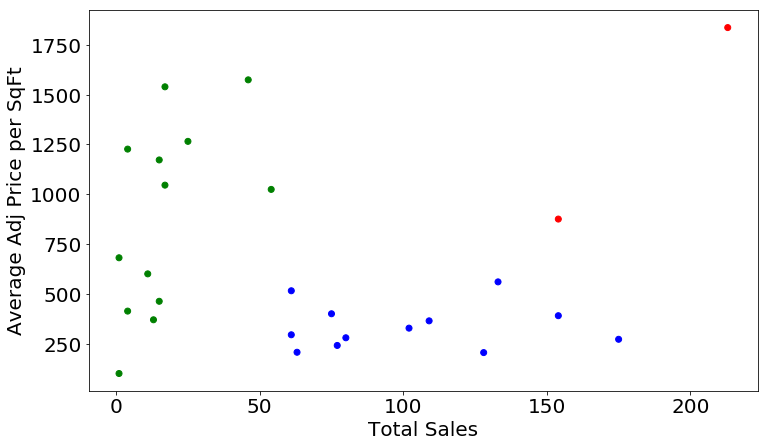

In [30]:
# Plot cluster
def get_color(x):
    if x in cluster1.index:
        return 'green'
    elif x in cluster2.index:
        return 'blue'
    else:
        return 'red'
    
cluster['color'] = cluster['neighborhood'].apply(get_color) 

fix, ax = plt.subplots(figsize=(12, 7))
ax.scatter(cluster['freq'], cluster['adj_p_sqft'], c=cluster['color'])
ax.axes.tick_params(labelsize=20)
ax.set_xlabel('Total Sales', size=20)
ax.set_ylabel('Average Adj Price per SqFt', size=20)

In [31]:
# Add group index to df based on the neighborhood clusters
def get_group(x):
    if x in cluster1.index:
        return 'low_freq'
    elif x in cluster2.index:
        return 'low_price_high_freq'
    else:
        return 'high_price_high_freq'
    
df['group'] = df['neighborhood'].apply(get_group)

Text(0,0.5,'Living Area')

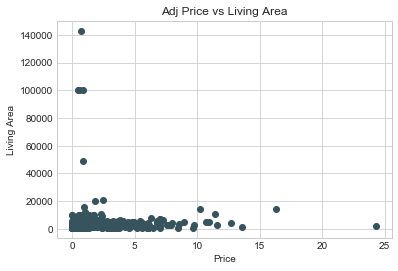

In [32]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')
plt.scatter(df['adj_price_m'], df['living_area'])
plt.title('Adj Price vs Living Area')
plt.xlabel('Price')
plt.ylabel('Living Area')

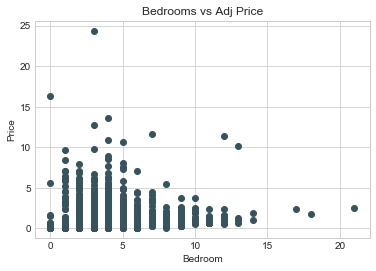

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [33]:
plt.scatter(df['bedrooms'], df['adj_price_m'])
plt.title('Bedrooms vs Adj Price')
plt.xlabel('Bedroom')
plt.ylabel('Price')
plt.show()
sns.despine

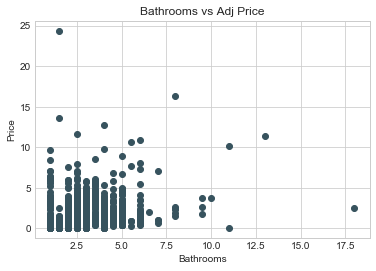

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [34]:
plt.scatter(df['bathrooms'], df['adj_price_m'])
plt.title('Bathrooms vs Adj Price')
plt.xlabel('Bathrooms')
plt.ylabel('Price')
plt.show()
sns.despine

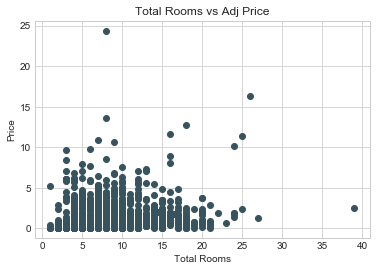

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [35]:
plt.scatter(df['total_rooms'], df['adj_price_m'])
plt.title('Total Rooms vs Adj Price')
plt.xlabel('Total Rooms')
plt.ylabel('Price')
plt.show()
sns.despine

Text(0.5,1,'Which is the pricey location by zipcode?')

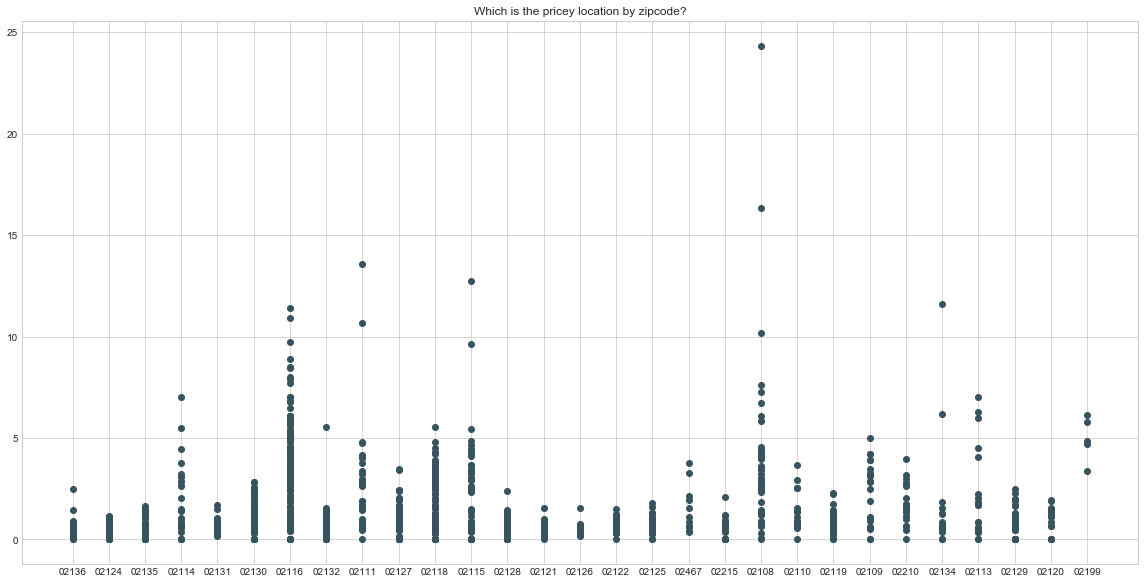

In [36]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(df['zipcode'], df['adj_price_m'])
plt.title('Which is the pricey location by zipcode?')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a219035c0>,
      dtype=object)

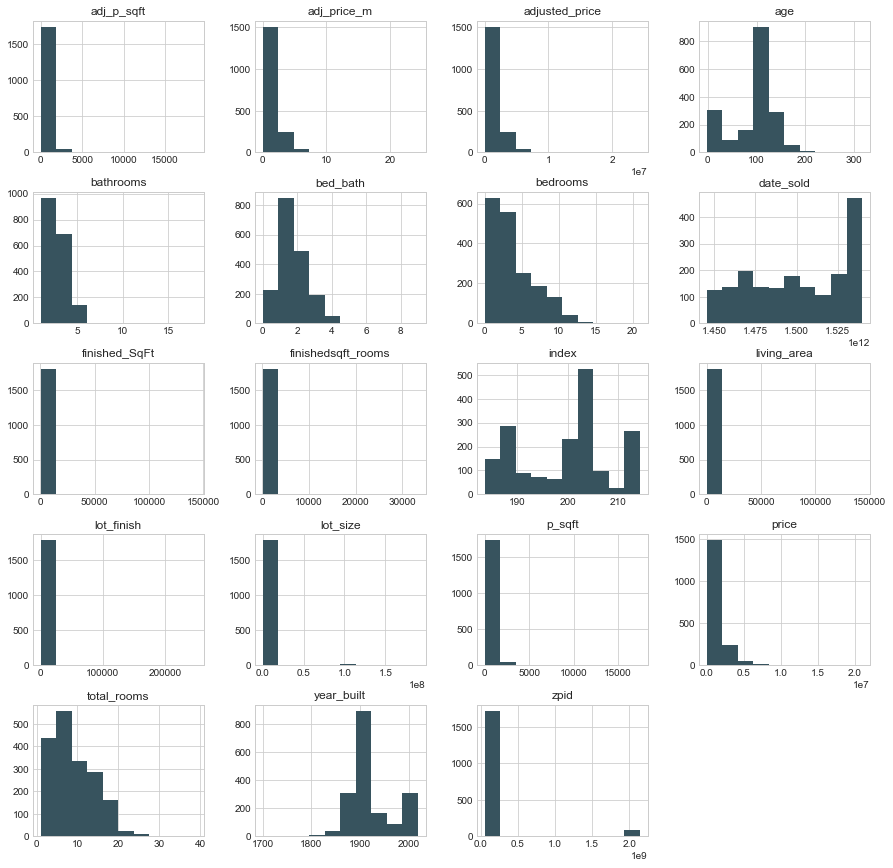

In [37]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
df.hist(ax=ax, stacked = True)

In [38]:
cols = list(df.columns.values) # Make a list of all of the columns in the df
cols.pop(cols.index('zpid')) # Remove zpid from list
df = df[cols+['zpid']] # Put zpid to last column of the df

In [ ]:
df.to_csv('all_types.csv')

In [39]:
all_df = pd.read_csv('all_types.csv')

Index(['adj_price_m', 'bathrooms', 'bedrooms', 'total_rooms', 'lot_size',
       'bed_bath', 'finished_SqFt', 'age', 'finishedsqft_rooms'],
      dtype='object')


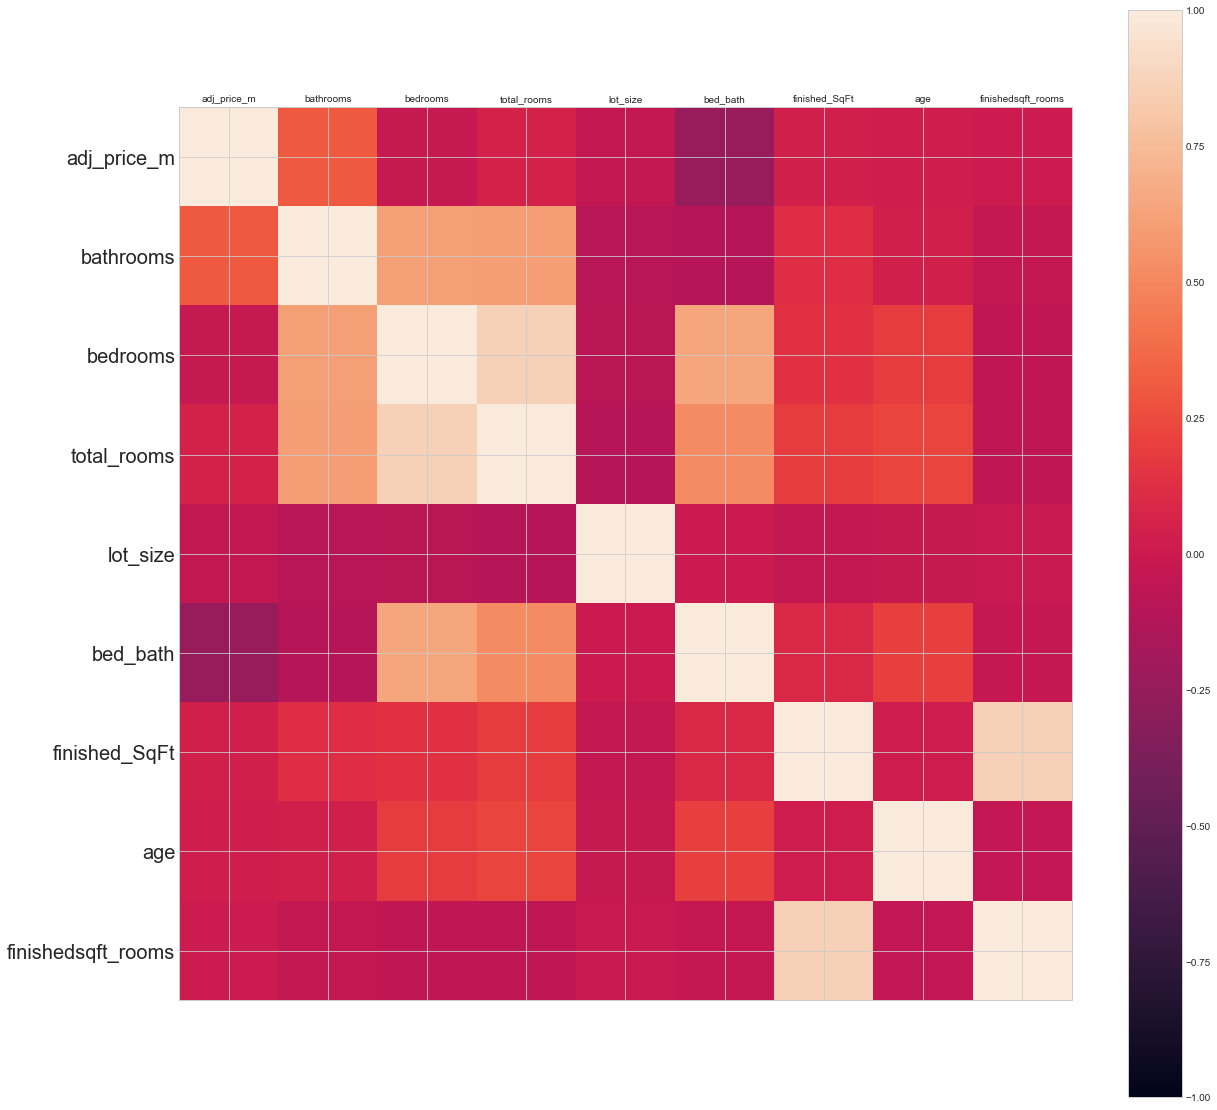

In [40]:
# Check correlations
correlations = all_df[['adj_price_m','bathrooms','bedrooms','total_rooms','lot_size','bed_bath','finished_SqFt','age',
      'finishedsqft_rooms']].corr()
names = all_df[['adj_price_m','bathrooms','bedrooms','total_rooms','lot_size','bed_bath','finished_SqFt','age',
      'finishedsqft_rooms']].keys()
print(names)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(names),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names,size=20)
plt.show()

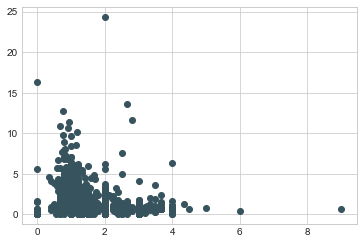

In [41]:
plt.scatter(all_df['bed_bath'], all_df['adj_price_m'])

# Data Analysis

In [42]:
# Training all dataset
y = all_df['adj_price_m']
X = all_df[['bathrooms','bedrooms','finished_SqFt','total_rooms','finishedsqft_rooms','bed_bath','age','lot_size',
        'lot_finish']]

# Create dummies for groups and home types
group = pd.get_dummies(all_df['group'])
home_type = pd.get_dummies(all_df['home_type'])

X = pd.concat([X,group,home_type],axis=1)

X.head()

,bathrooms,bedrooms,finished_SqFt,total_rooms,finishedsqft_rooms,bed_bath,age,lot_size,lot_finish,high_price_high_freq,low_freq,low_price_high_freq,APARTMENT,CONDO,MULTI_FAMILY,SINGLE_FAMILY,TOWNHOUSE
0,4.0,9,4765.0,16.0,297.812500,2.250000,126,9703,2.036306,0,0,1,0,0,1,0,0
1,3.0,6,3900.0,15.0,260.000000,2.000000,106,2717,0.696667,0,0,1,0,0,0,1,0
2,7.0,10,3600.0,17.0,211.764706,1.428571,96,3484,0.967778,0,0,1,0,0,1,0,0
3,5.0,6,2900.0,11.0,263.636364,1.200000,86,3920,1.351724,0,0,1,0,0,1,0,0
4,4.0,3,2400.0,10.0,240.000000,0.750000,126,675,0.281250,0,1,0,0,0,1,0,0


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Linear Regression

0.15727270404491064
Linear Regression R squared": -1.1774
Linear Regression RMSE: 2.6882
Linear Regression MAE: 0.9434


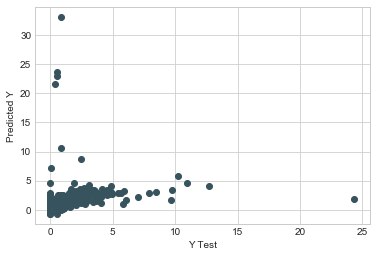

In [45]:
# Linear Regression
lm = LinearRegression()

lm.fit(X_train,y_train)
predictions = lm.predict(X_test)

plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

print(np.mean(cross_val_score(lm, X_train.iloc[:,:-1], y_train)))

# Calculate R squared
# -117% of the variability in Y can be explained using X
print('Linear Regression R squared": %.4f' % lm.score(X_test, y_test))

# Calculate root-mean-square error (RMSE)
# The model was able to predict the value of every house in the test set within $2,688,200 of the real price
lin_mse = mean_squared_error(predictions, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: %.4f' % lin_rmse)

# Calculate mean absolute error (MAE)
lin_mae = mean_absolute_error(predictions, y_test)
print('Linear Regression MAE: %.4f' % lin_mae)

## Decision Tree Regression

In [46]:
# Regression tree
# The depth of the tree is choosen by cross validation
score = []
for i in range(1,15):
    dt = DecisionTreeRegressor(max_depth=i)
    score += [np.mean(cross_val_score(dt, X_train.iloc[:,:-1], y_train))]

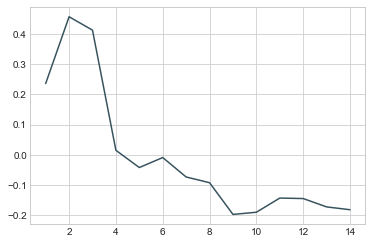

In [47]:
plt.plot(range(1,15),score)

In [48]:
dt = DecisionTreeRegressor(max_depth=2)
dt.fit(X_train,y_train)

predictions = dt.predict(X_test)
np.mean(cross_val_score(dt, X_train.iloc[:,:-1], y_train))

# Calculate R squared
print('Decision Tree Regression R squared": %.4f' % dt.score(X_test, y_test))

# Calculate root-mean-square error (RMSE)
lin_mse = mean_squared_error(predictions, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Decision Tree Regression RMSE: %.4f' % lin_rmse)

# Calculate mean absolute error (MAE)
lin_mae = mean_absolute_error(predictions, y_test)
print('Decision Tree Regression MAE: %.4f' % lin_mae)

Decision Tree Regression R squared": 0.3132
Decision Tree Regression RMSE: 1.5098
Decision Tree Regression MAE: 0.6726


## Random Forest Regression

In [49]:
# Randomforest regression
# For different number of trees, test different depth
num_trees = [10,20,40,100]
d_score = {}
for e in num_trees:
    for i in range(1,15):
        rf = RandomForestRegressor(n_estimators=e, max_depth=i)
        if e in d_score:
            d_score[e] += [np.mean(cross_val_score(rf, X_train.iloc[:,:-1], y_train))]
        else:
            d_score[e] = [np.mean(cross_val_score(rf, X_train.iloc[:,:-1], y_train))]

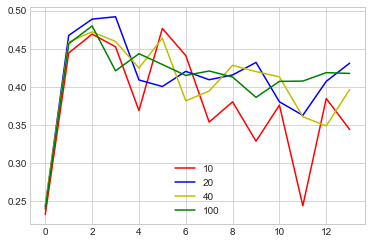

In [50]:
pd.DataFrame(d_score).plot(style=['r', 'b', 'y', 'g'])

In [51]:
rf = RandomForestRegressor(n_estimators=20, max_depth=3)

rf.fit(X_train,y_train)

predictions = rf.predict(X_test)
np.mean(cross_val_score(rf, X_train.iloc[:,:-1], y_train))

# Calculate R squared
print('Random Forest Regression R squared": %.4f' % rf.score(X_test, y_test))

# Calculate root-mean-square error (RMSE)
lin_mse = mean_squared_error(predictions, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Random Forest Regression RMSE: %.4f' % lin_rmse)

# Calculate mean absolute error (MAE)
lin_mae = mean_absolute_error(predictions, y_test)
print('Random Forest Regression MAE: %.4f' % lin_mae)

Random Forest Regression R squared": 0.3172
Random Forest Regression RMSE: 1.5054
Random Forest Regression MAE: 0.6637


## Gradient Boosting Regression

In [52]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor

gbr = ensemble.GradientBoostingRegressor()
gbr.fit(X_train, y_train)
predictions = gbr.predict(X_test)
np.mean(cross_val_score(gbr, X_train.iloc[:,:-1], y_train))

# Calculate R squared
print('Gradient Boosting Regression R squared": %.4f' % gbr.score(X_test, y_test))

# Calculate root-mean-square error (RMSE)
lin_mse = mean_squared_error(predictions, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Gradient Boosting Regression RMSE: %.4f' % lin_rmse)

# Calculate mean absolute error (MAE)
lin_mae = mean_absolute_error(predictions, y_test)
print('Gradient Boosting Regression MAE: %.4f' % lin_mae)



Gradient Boosting Regression R squared": 0.3176
Gradient Boosting Regression RMSE: 1.5049
Gradient Boosting Regression MAE: 0.6181


## Important Features

In [54]:
# Find out which features are important
# The most important features are finished sqft per room, finished sqft, total rooms, 
# lot size and so on. And the least important feature is Townhouse, which means that 
# regardless of whether this unit is townhouse or not
feature_labels = np.array(['bathrooms','bedrooms','finished_SqFt','total_rooms','finishedsqft_rooms','bed_bath','age','lot_size',
        'lot_finish','high_price_high_freq','low_freq','low_price_high_freq','APARTMENT','CONDO','MULTI_FAMILY','SINGLE_FAMILY','TOWNHOUSE'])
importance = gbr.feature_importances_
feature_indexes_by_importance = importance.argsort()
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

TOWNHOUSE-0.00%
SINGLE_FAMILY-0.31%
APARTMENT-0.75%
bedrooms-1.44%
MULTI_FAMILY-1.65%
CONDO-2.36%
high_price_high_freq-2.45%
low_freq-3.47%
bed_bath-3.77%
age-6.21%
bathrooms-6.57%
low_price_high_freq-7.70%
lot_finish-8.21%
lot_size-9.65%
total_rooms-10.05%
finished_SqFt-11.81%
finishedsqft_rooms-23.60%


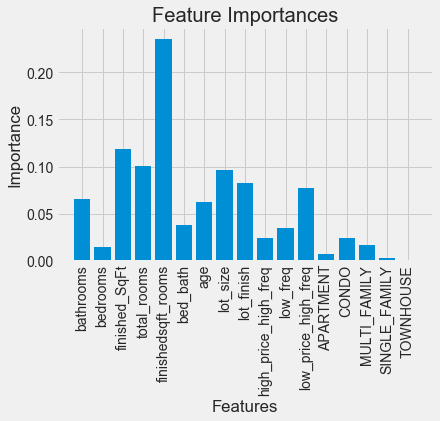

In [55]:
# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importance)))
# Make a bar chart
plt.bar(x_values, importance, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_labels, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Features'); plt.title('Feature Importances');